# Plot $\tiny\Delta$TS using locally generated scan results

If you are able to get `numpy` files from `perform_scan.py`, then you can plot the results of analysis using this notebook.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D


from scipy.integrate import quad
from scipy.optimize import curve_fit, newton
from scipy.interpolate import interp1d

from glob import glob
from pathlib import Path
import os
import sys
sys.path.append('../')
from src import plot_utils
from src.fill_table import *
import pandas as pd
from pathlib import Path

analysisconfig = AnalysisConfig()
analysisconfig.set_datapath()


%matplotlib inline
plot_utils.mpl_settings()

Set manually the source name

In [2]:
source_name = analysisconfig.get_source()
source_name

'VelaX'

In [3]:
f_input = 0.0  # leptonic
# f_input = 1.0  # hadronic

In [4]:
scan_values = np.linspace(0.0, 1.0, 21)

Set path to `numpy` files

In [5]:
data_path = analysisconfig.datapath / "likelihood_analysis" / "numpy_files" / source_name / str(f_input)
data_path

PosixPath('/home/msmirnov/working_space/cta-and-km3net/data/likelihood_analysis/numpy_files/VelaX/0.0')

In [6]:
### Here we read the .npy files produced by the "perform_scan.py" script and gather the output in one csv file.

df_dict=dict(case=[], seed=[], f_value=[], stat_total=[], stat_gamma=[], stat_nu=[], int_PD=[], int_IC=[])
# read and append scans for Case1
for idx,filename in enumerate(glob('{}/*.npy'.format(data_path / 'Case1'))):
    file = np.load(filename, allow_pickle=True).flat[0]
    n = len(file["values"])
    df_dict["seed"].append([int(filename[-7:-5].replace("_", "0"))]*n)
    df_dict['f_value'].append(file["values"])
    df_dict['case'].append(np.ones(n, dtype=int)) 
    df_dict['stat_total'].append(file['stat_no_prior'] - np.min(file['stat_no_prior']))
    df_dict['stat_gamma'].append(file['stat_no_prior'] - np.min(file['stat_no_prior']))
    df_dict['stat_nu'].append(np.zeros(n))
    df_dict['int_PD'].append(file['int_PD'])
    df_dict['int_IC'].append(file['int_IC'])

In [7]:
# read and append scans for Case2
for idx,filename in enumerate(glob('{}/*.npy'.format(data_path/ 'Case2'))):
    file = np.load(filename, allow_pickle=True).flat[0]
    n = len(file["values"])
    df_dict["seed"].append([int(filename[-7:-5].replace("_", "0"))]*n)
    df_dict['f_value'].append(file["values"])
    df_dict['case'].append(np.ones(n, dtype=int)*2) 
    df_dict['stat_total'].append(file['stat'] - np.min(file['stat']))
    df_dict['stat_gamma'].append(np.zeros(n))
    df_dict['stat_nu'].append(file['stat'] - np.min(file['stat']))
    df_dict['int_PD'].append(file['int_PD'] / file['int_had'])
    df_dict['int_IC'].append(np.zeros(n))

In [8]:
# read and append scans for Case3
for idx,filename in enumerate(glob('{}/*.npy'.format(data_path / 'Case3'))):
    file = np.load(filename, allow_pickle=True).flat[0]
    n = len(file["values"])
    df_dict["seed"].append([int(filename[-7:-5].replace("_", "0"))]*n)
    df_dict['f_value'].append(file["values"])
    df_dict['case'].append(np.ones(n, dtype=int)*3) 
    stat_total_no_prior = file['stat_gamma_no_prior'] + file['stat_nu']
    df_dict['stat_total'].append(stat_total_no_prior - np.min(stat_total_no_prior))
    df_dict['stat_gamma'].append(file['stat_gamma_no_prior'] - np.min(file['stat_gamma_no_prior']))
    df_dict['stat_nu'].append(file['stat_nu'] - np.min(file['stat_nu']))
    df_dict['int_PD'].append(file['int_PD'])
    df_dict['int_IC'].append(file['int_IC'])

In [12]:
# Create pandas DataFrame from numpy files
try:
    for k,v in df_dict.items():
        df_dict[k] = np.concatenate(v)
    df = pd.DataFrame(df_dict)
except ValueError:
    print("check if numpy files were produced by perform_scan.py")

check if numpy files were produced by perform_scan.py


In [10]:
#show first 3 rows
df.head(n=3)

,case,seed,f_value,stat_total,stat_gamma,stat_nu,int_PD,int_IC
0,1,1,0.00,0.000000,0.000000,0.0,0.000000e+00,4.466652e-11
1,1,1,0.05,0.222921,0.222921,0.0,2.304878e-12,4.243829e-11
2,1,1,0.10,0.610297,0.610297,0.0,4.611793e-12,4.021501e-11


In [11]:
# First scenario: CTA only
TS1 = []
int_PD1 = []
int_IC1 = []

for idx,filename in enumerate(glob('{}/*.npy'.format(data_path / 'Case1'))):
    file = np.load(filename, allow_pickle=True).flat[0]
    TS1.append(file['stat_no_prior'] - np.min(file['stat_no_prior']))
    int_PD1.append(file['int_PD'])
    int_IC1.append(file['int_IC'])

print('Found', len(TS1), 'realizations')
TS1_avg = np.mean(np.array(TS1), axis=0)
int_PD1_avg = np.mean(np.array(int_PD1), axis=0)
int_IC1_avg = np.mean(np.array(int_IC1), axis=0)
f1_avg = int_PD1_avg / (int_PD1_avg + int_IC1_avg)

Found 1 realizations


In [12]:
# Second scenario: KM3NeT only
TS2 = []
int_PD2 = []

for idx,filename in enumerate(glob('{}/*.npy'.format(data_path / 'Case2'))):
    file = np.load(filename, allow_pickle=True).flat[0]
    if np.all(np.isfinite(file['int_PD'])):
        int_PD2.append(file['int_PD'] / file['int_had'])
        TS2.append(file['stat'] - np.min(file['stat']))
    else:
        print(filename)

print('Found', len(TS2), 'realizations')
TS2_avg = np.mean(np.array(TS2), axis=0)
f2_avg = np.mean(np.array(int_PD2), axis=0)

Found 1 realizations


In [13]:
# Third scenario: Combined
TS3 = []
TS3_nu = []
TS3_gamma = []
int_PD3 = []
int_IC3 = []

for idx,filename in enumerate(glob('{}/*.npy'.format(data_path / 'Case3'))):
    file = np.load(filename, allow_pickle=True).flat[0]
    ts_nu = file['stat_nu'] - np.min(file['stat_nu'])
    ts_gamma = file['stat_gamma_no_prior'] - np.min(file['stat_gamma_no_prior'])
    int_PD3.append(file['int_PD'])
    int_IC3.append(file['int_IC'])

    TS3.append(ts_nu + ts_gamma)
    TS3_nu.append(ts_nu)
    TS3_gamma.append(ts_gamma)

print('Found', len(TS3), 'realizations')
TS3_avg = np.mean(np.array(TS3), axis=0)
TS3_nu_avg = np.mean(np.array(TS3_nu), axis=0)
TS3_gamma_avg = np.mean(np.array(TS3_gamma), axis=0)

int_PD3_avg = np.mean(np.array(int_PD3), axis=0)
int_IC3_avg = np.mean(np.array(int_IC3), axis=0)
f3_avg = int_PD3_avg / (int_PD3_avg + int_IC3_avg)

Found 1 realizations


In [14]:
# Compute quantiles for TS3
TS3_quantiles95 = np.quantile(TS3, [0.05, 0.95], axis=0)
TS3_quantiles68 = np.quantile(TS3, [1-0.68, 0.68], axis=0)

TS12_quantiles95 = np.quantile(np.array(TS1)+TS2, [0.05, 0.95], axis=0)
TS12_quantiles68 = np.quantile(np.array(TS1)+TS2, [1-0.68, 0.68], axis=0)

In [15]:
# in order to have the same ylim for lep and had
# set by the max of the limits
ylim_dct={'HESSJ1908':(-1.777, 17.615),
         'Westerlund1':(-2.434, 30.003),
          'VelaX':(-4.864, 84.895),
          'RXJ1713':(-1.555, 17.866)}

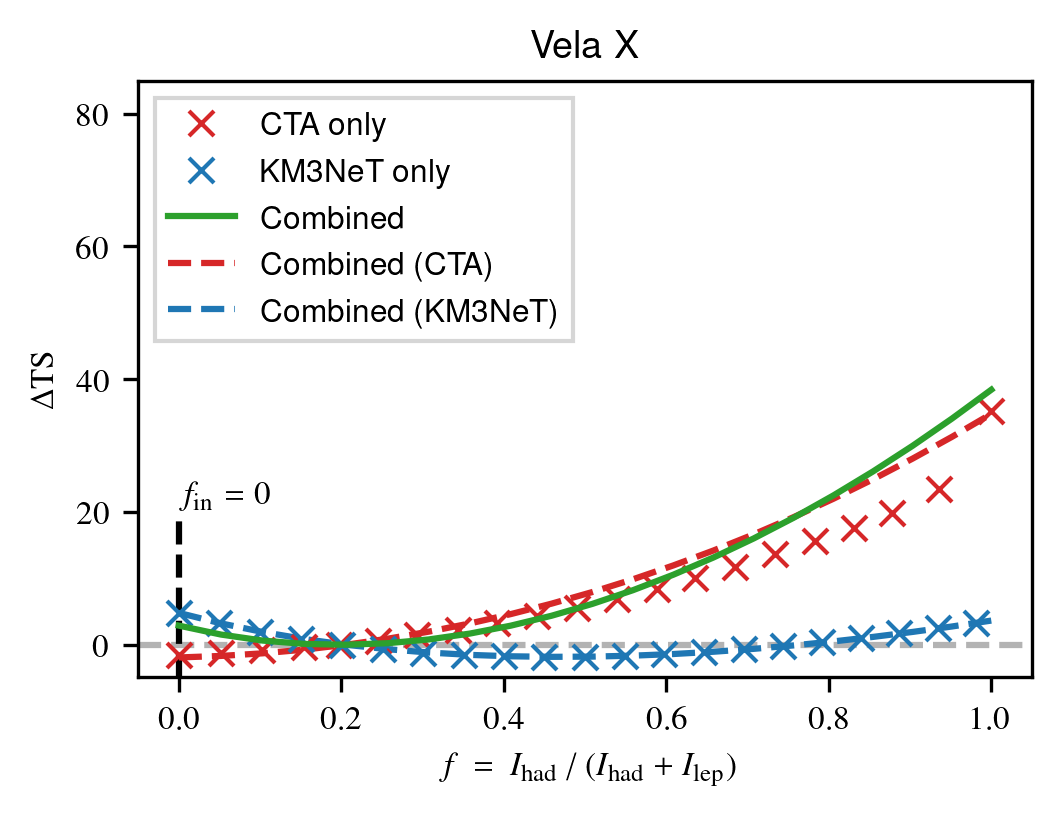

In [16]:
fig_width = 8.8 / 2.54
ax_width = 0.86
fig_height = 2.6
ax_height = fig_width * ax_width / 1.5 / fig_height

fig = plt.figure(figsize=(fig_width, fig_height), dpi=300)
ax = fig.add_axes([0.13, 0.15, ax_width, ax_height])
ax.set_title(plot_utils.source_name_labels[source_name])
ax.set_xlabel('$f\,=\,I_\mathrm{had}\,/\,(I_\mathrm{had} + I_\mathrm{lep})$')
ax.set_ylabel('$\Delta \mathrm{TS}$')

idx_norm = TS3_avg.argmin()

ax.plot(f1_avg, TS1_avg-TS1_avg[idx_norm], 'x', c='tab:red', label='CTA only', zorder=4)
ax.plot(f2_avg, TS2_avg-TS2_avg[idx_norm], 'x', c='tab:blue', label='KM3NeT only', zorder=4)
ax.plot(f3_avg, TS3_avg-TS3_avg[idx_norm], '-', c='tab:green', label='Combined', zorder=5)
ax.plot(f3_avg, TS3_gamma_avg-TS3_gamma_avg[idx_norm], '--', c='tab:red', label='Combined (CTA)', zorder=3)
ax.plot(f3_avg, TS3_nu_avg-TS3_nu_avg[idx_norm], '--', c='tab:blue', label='Combined (KM3NeT)', zorder=3)

ax.fill_between(f3_avg, TS3_quantiles95[0,:]-TS3_avg[idx_norm], TS3_quantiles95[1,:]-TS3_avg[idx_norm],
                color='tab:green', linewidth=0.0, alpha=0.3, zorder=1)
ax.fill_between(f3_avg, TS3_quantiles68[0,:]-TS3_avg[idx_norm], TS3_quantiles68[1,:]-TS3_avg[idx_norm],
                color='tab:green', linewidth=0.0, alpha=0.3, zorder=1)

ax.hlines(0, -0.05, 1.05, color='0.7', ls='--', zorder=2)
ax.axvline(f_input, ymax=0.27, color='k', ls='--', zorder=2)
trans = plt.matplotlib.transforms.blended_transform_factory(ax.transData, ax.transAxes)
ha_dict = {0.:'left', 0.5:'center', 1.0:'right'}
ax.text(f_input, 0.28, '$f_\mathrm{{in}} = {:g}$'.format(f_input), ha=ha_dict[f_input], va='bottom',
        color='k', transform=trans)
y1,y2 = ax.get_ylim()
        
ax.set_xlim(-0.05, 1.05)
if source_name in ylim_dct.keys():
    ax.set_ylim(ylim_dct[source_name])

leg_loc = {0.:'upper left', 0.5:'upper center', 1.0:'upper right'}
ax.legend(loc=leg_loc.get(f_input, 'upper left'))
plt.show()